# (0) Librairies

In [7]:
# (1) Importation des données
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

import openml
from openml import datasets as ml

# (2) Détecteur de 5
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

# (1) Importation des données

On sépare les images dans ```images``` et les labels dans ```labels```, on les mélange puis on crée un jeu de test et un d'entrainement.\
On règlera les algorithmes en fonction des évaluations croisées sur le jeu d'entrainement avant de faire un test final sur le jeu de test.

In [8]:
dataset = ml.get_dataset(554)
data, y, cat_indicator, att_names = dataset.get_data(dataset_format = 'dataframe')

# Jeux de test et d'entrainement
shuffle_index = np.random.permutation(70000)

Train = data.iloc[shuffle_index[:60000]] # <pandas.core.frame.DataFrame>
Test = data.iloc[shuffle_index[60000:70000]] # <pandas.core.frame.DataFrame>

# Création d'index
Train.set_index(np.arange(0, 60000), inplace = True)
Test.set_index(np.arange(0, 10000), inplace = True)

# Séparation des images et des étiquettes
Train_img = Train.drop('class', axis = 1, inplace = False)
Train_lab = Train['class']
Test_img = Test.drop('class', axis = 1, inplace = False)
Test_lab = Test['class']

/var/folders/l4/tj2026g138127nm7gbw5ljb00000gn/T/ipykernel_12077/3413094728.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = ml.get_dataset(554)


### Utilisation basique des données

On affiche le ième image du jeu de données avec son étiquette.

4


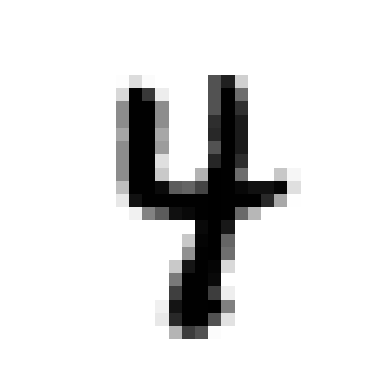

In [9]:
def affiche_data(i):
    print(data['class'][i]) # Affichage de l'étiquette

    # Affichage de l'image
    img = data.drop('class', axis = 1, inplace = False).iloc[i]
    img_tab = np.array(img).reshape((28, 28)).astype('float')

    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()
    
def affiche_Train(i):
    print(Train_lab.iloc[i])

    img = Train_img.iloc[i]
    img_tab = np.array(img).reshape((28, 28)).astype('float')
    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()

def affiche_Test(i):
    print(Test_lab.iloc[i])

    img = Test_img.iloc[i]
    img_tab = np.array(img).reshape((28, 28)).astype('float')
    fig = plt.figure(frameon=False)
    im2 = plt.imshow(img_tab, cmap = matplotlib.cm.binary, interpolation="nearest") 
    plt.axis("off")

    plt.show()
    
n = 283
affiche_Test(n)

# (2) Détecteur de 5

Nous allons commencer par détecter si un chiffre est un 5 ou non (classificateur binaire).

On commence par crée un vecteur d'étiquettes booléennes qui sont vraies si l'image est un 5:

In [10]:
X = Train_img.copy()
y_5 = (Train_lab == '5').copy()

On choisit ensuite un classificateur que l'on entraine avec les données:

In [30]:
nbDonnees = 48000
shuffle_index = np.random.permutation(60000)
index_train = shuffle_index[:nbDonnees]
index_test = shuffle_index[nbDonnees:]

sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X.iloc[index_train], y_5.iloc[index_train])

SGDClassifier(random_state=42)

## a) Evaluation des performances

### Première évaluation

Une première façon de faire est de tester le nombre de prédiction correcte:

In [31]:
y_pred = sgd_clf.predict(X.iloc[index_test])
taux_pred = sum(y_pred == y_5[index_test]) / (60000 - nbDonnees)
taux_pred

0.9569166666666666

Sachant que le classificateur le plus bête (qui classe tout en non-5) aurait un score de 90%, un score de 96% n'est pas très bon.

### Matrice de confusion

Il s'agit d'une matrice dont chaque ligne représente une étiquette (ici: 5), chaque colonne une prédiction (ici: non-5), et un coefficients (i,j) est donc le nombre de données avec l'étiquette i étant prédit avec l'étiquette j. \
On obtient les nombres de vrais/faux positifs/négatifs:

In [44]:
confusion = confusion_matrix(y_5[index_test], y_pred)
TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

print(confusion)
print(confusion / (60000 - nbDonnees)) # Coefficient en pourcentage

[[10848    56]
 [  477   619]]
[[0.904      0.00466667]
 [0.03975    0.05158333]]


### Précision et rappel

Cette matrice devenant plus complexe lorsqu'on a beaucoup de classes, on utilise des outils plus simple.

On peut s'interresser aux valeurs réelles ou aux prédictions, positives ou négatives, classées correctement ou non. <br>
On définit ainsi 8 taux, quatre de rappel:
* ```TPR```: Taux de 5 détecté comme 5 (Rappel Positif, ou True Positif Rate)
* ```FNR``` = 1 - ```TPR```: Taux de 5 détecté comme non-5 (Oubli Positif, ou False Negatif Rate)
* ```TNR```: Taux de non-5 détecté comme non-5 (Rappel Négatif, ou True Negatif Rate, ou spécificité)
* ```FPR``` = 1 - ```TNR```: Taux de non 5 détecté comme 5 (Oubli Négatif, ou False Positif Rate)

Et quatre de précision
* ```precision```: Taux de prédictions 5 correctes (Précision positive)
* ```imprecision```: Taux de prédiction 5 incorrectes (Imprécision positive)
* ```prec_neg```: Taux de prédictions non-5 correctes (Précision négative)
* ```imprec_neg```: Taux de prédictions non-5 incorrectes (Imprécision négative)

In [45]:
TPR = TP / (TP + FN)
FNR = FN / (TP + FN)

TNR = TN / (TN + FP)
FPR = FP / (TN + FP)

precision = TP / (TP + FP)
imprecision = FP / (TP + FP)

prec_neg = TN / (TN + FN)
imprec_neg = FN / (TN + FN)

### Moyenne harmonique

La moyenne harmonique de n taux est définie par: $M_{harmonique} = n / \sum_{k = 1}^{n} \frac{1}{taux_k}$. \
Elle privilégie les taux similaires. Par exemple pour des taux de 0.25 et 0.75, la moyenne sera de 0.375, alors que pour deux taux de 0.5, la moyenne sera de 0.5.

In [46]:
F1 = 2 / (1 / precision + 1 / TPR) # Score F1, moyenne de la précision et du rappel
F4 = 4 / sum([1 / taux for taux in [TPR, TNR, precision, prec_neg]])
F4_false = 4 / sum([1 / taux for taux in [FNR, FPR, imprecision, imprec_neg]])

print('Précision: {} \nRappel: {} \nF1: {} \nF4: {} \nF4_false: {}'.format(precision, TPR, F1, F4, F4_false))

Précision: 0.917037037037037 
Rappel: 0.5647810218978102 
F1: 0.6990400903444383 
F4: 0.8146308156068689 
F4_false: 0.017181563073918767


### Autres scores
Le score F1 favorise les classificateurs ayant une précision et un rappel similaire. Parfois, il faut accorder davantage d'importance à la précision, parfois au rappel (selon le problème à résoudre). \
C'est pourquoi on modifie le seuil à partir duquel une image est classée comme étant un 5 et on privilégie d'autres scores.


In [47]:
y_scores = sgd_clf.decision_function(X.iloc[index_test]) # <np.ndarray> shape nbDonnees

threshold = 295 # Seuil: 9905 pour un rappel de 1
y_pred = y_scores > threshold

confusion = confusion_matrix(y_5[index_test], y_pred)

TP = confusion[1][1]
FP = confusion[0][1]
TN = confusion[0][0]
FN = confusion[1][0]

Precision = TP / (TP + FP)
Rappel = TP / (TP + FN)
F1 = 2 / (1/Precision + 1/Rappel)
print('Precision: ', Precision, '\nRappel: ', Rappel, '\nF1: ', F1)

Precision:  0.917037037037037 
Rappel:  0.5647810218978102 
F1:  0.6990400903444383


On peut ainsi afficher des graphiques pour choisir le compromis à faire:
* Précision/Rappel (```precision```/```TPR```)
* ROC (```TPR```/```FPR```)
* Seuil (Courbe de rappel et de précision en fonction du seuil)
* ...

#### Affichage des graphiques

In [78]:
def affichage(yArg_true, yArg_scores, thresholds = range(-5000, 5000, 100), xStr = 'threshold', yLst = ['precision', 'TPR', 'prec_neg', 'TNR']):
    """Affiche les courbes définies dans yLst en fonction de xStr

    IN:
        yArg_true (array-like): shape n, liste des labels réels
        yArg_scores (array-like): shape n, liste des scores des labels prédits
        thresholds (array-like): shape n, liste des seuils
        xStr (str): abscisse du graphique
        yLst (lst of str): ordonnées du graphique
    """
    
    P = sum(yArg_true) # Nombre de positifs
    N = len(yArg_true) - P # Nombre de négatifs
    T = len(thresholds)
    TP, FP , TN, FN = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)
    
    # Récupération des vrais/faux positifs/négatifs
    for i, threshold in enumerate(thresholds):
        y_pred = yArg_scores > threshold
        confusion = confusion_matrix(yArg_true, y_pred)

        TP[i] = confusion[1][1]
        FP[i] = confusion[0][1]
        
        TN[i] = confusion[0][0]
        FN[i] = confusion[1][0]
        
    # Définition de l'abscisse (u[0]) et des ordonnées (u[i], i > 0)
    u = []
    
    for uStr in [xStr] + yLst:
        match uStr:
            case 'threshold': u += [thresholds]
            
            case 'TPR': u += [TP / (TP + FN)]
            case 'FNR': u += [FN / (TP + FN) ]

            case 'TNR': u += [TN / (TN + FP) ]
            case 'FPR': u += [FP / (TN + FP) ]

            case 'precision': u += [TP / (TP + FP)]
            case 'imprecision': u += [FP / (TP + FP)]

            case 'prec_neg': u += [TN / (TN + FN) ]
            case 'imprec_neg': u += [FN / (TN + FN) ]
    
    # Affichage
    for i, y in enumerate(u[1:]):
        plt.plot(u[0], y, label=yLst[i]) 
        
    plt.xlabel(xStr)
    plt.legend(loc="lower left")
    plt.show()
    # plt.ylim([0, 1])

##### Courbe rappel/précision

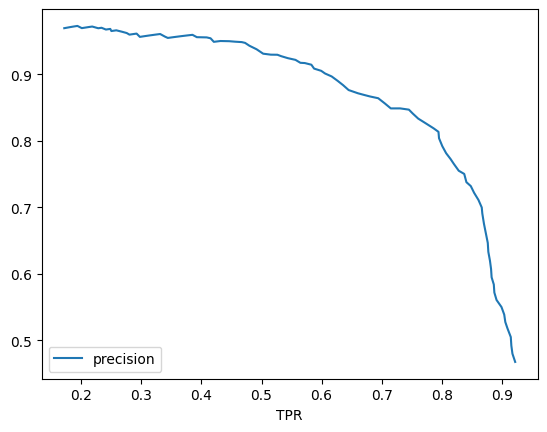

In [50]:
abscisse = 'TPR'
ordonnees = ['precision']

affichage(y_5[index_test], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)

##### Courbe ROC

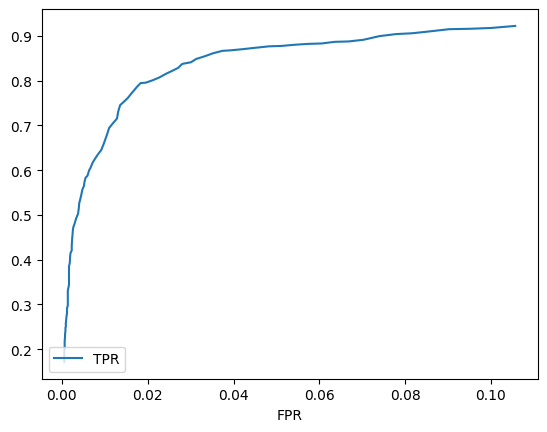

In [52]:
abscisse = 'FPR'
ordonnees = ['TPR']

affichage(y_5[index_test], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)

##### Courbes seuil

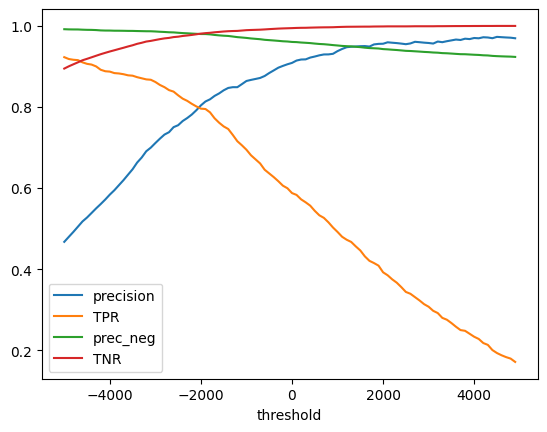

In [53]:
abscisse = 'threshold'
ordonnees = ['precision', 'TPR', 'prec_neg', 'TNR']

affichage(y_5[index_test], y_scores, range(-5000, 5000, 100), abscisse, ordonnees)

### Résumé
Avec ```.decision_function```, on calcule un score pour chaque image indiquant s'il s'agit d'un 5. On définit un seuil à partir duquel on décide de classer l'image en 5.\
On dispose de quatre scores bruts: ```TP```, ```FP```, ```TN```, ```FN```.\
On peut définir quatre scores combinés: ```TPR```, ```TNR```, ```precision```, ```prec_neg```.\
On peut calculer la moyenne harmonique de plusieurs scores qui privilégie les scores similaires.\
Pour décider du seuil à utiliser, on affiche des graphiques. On dispose de deux types de graphiques:
- Ceux qui admettent des scores en abscisse et en ordonnée.
- Ceux qui admettent le seuil en abscisse et un ou plusieurs scores en ordonnées.

### Implémentation des méthodes de scoring
On réimplémentante la fonction ```affichage``` pour l'adapter à la validation croisée.

In [92]:
def scoring(yArg_true, yArg_probas, thresholds = range(-5000, 5000, 100)):
    """Calcul les scores TPR, TNR, precision, prec_neg pour chaque valeur de thresholds

    IN:
        yArg_true <array-like>: liste des labels réels
        yArg_probas <list of tuple of <array_like, index> >: liste des scores des labels prédits
        thresholds <array-like>: liste des seuils
    OUT: <dict of list> Le dictionnaire a pour clés les noms des scores au format <str>
                                               valeurs les listes des scores en fonction des valeurs de thresholds
    """

    scores = {'TPR': [], 'TNR': [], 'precision': [], 'prec_neg': []}
    taille = len(yArg_probas)
    for i, threshold in enumerate(thresholds):
        TPs, FPs, TNs, FNs = np.zeros(taille), np.zeros(taille), np.zeros(taille), np.zeros(taille) # 

        for j, probaIndex in enumerate(yArg_probas):
            y_proba, index = probaIndex[0], probaIndex[1]

            # Récupération des vrais/faux positifs/négatifs
            y_pred = y_proba > threshold
            confusion = confusion_matrix(yArg_true[index], y_pred)

            TPs[j] = confusion[1][1]
            FPs[j] = confusion[0][1]
            
            TNs[j] = confusion[0][0]
            FNs[j] = confusion[1][0]
            
        TP = sum(TPs)
        FP = sum(FPs)
        TN = sum(TNs)
        FN = sum(FNs)

        scores['TPR'] += [TP / (TP + FN)]
        scores['TNR'] += [TN / (TN + FP)]
        scores['precision'] += [TP / (TP + FP)]
        scores['prec_neg'] += [TN / (TN + FN)]
    
    return scores


def affichage(yArg_true, yArg_probas, thresholds = range(-5000, 5000, 100), scoresToPrint = ['TPR', 'TNR', 'precision', 'prec_neg']):
    """Affiche les courbes des scores spécifiés dans scoresToPrint en fonction de thresholds

    IN:
        yArg_true <array-like>: liste des labels réels
        yArg_probas <list of tuple of <array_like, index> >: liste des scores des labels prédits
        thresholds <array-like>: liste des seuils
        scores <list of str>: liste des scores à afficher
    """
    
    scores = scoring(yArg_true, yArg_probas, thresholds)
    
    # Affichage
    for scoreName in scoresToPrint:
        plt.plot(thresholds, scores[scoreName], label = scoreName) 
        
    plt.legend(loc="lower left")
    plt.show()




### Implémentation de la validation croisée

On divise le jeu en ```nbPasse``` jeux.

In [94]:
def valid_croisee(model, XArg, yArg, nbPasse = 2):
    # IN: model: modele de classification
    #     XArg <DataFrame>: Nombre de division pour la validation croisée
    #     yArg <int>: Nombre de division pour la validation croisée
    #     nbPasse <int>: Nombre de division pour la validation croisée
    skfolds = StratifiedKFold(n_splits=nbPasse, random_state = 42, shuffle = True)

    y_proba = []

    for train_index, test_index in skfolds.split(XArg, yArg): 
        clone_clf = clone(model)
        
        X_train = XArg.iloc[train_index]
        y_train = yArg.iloc[train_index]

        X_test = XArg.iloc[test_index]
        
        clone_clf.fit(X_train, y_train)
        
        proba = clone_clf.decision_function(X_test)
        y_proba += [(proba, test_index)]

    return y_proba

y_proba = valid_croisee(model = sgd_clf, XArg = X, yArg = y_5, nbPasse = 8)

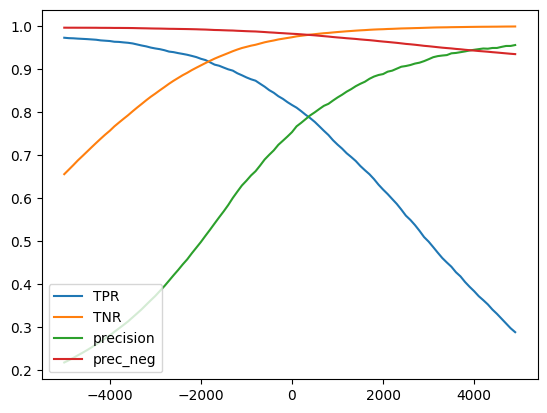

In [95]:
affichage(yArg_true= y_5, yArg_probas= y_proba)

## b) Recherche et évaluation d'autres modèles


In [105]:
X = Train_img.copy()
y_5 = (Train_lab == '5').copy()

def affichage(y_true, y_proba, thresholds = range(-5000, 5000, 100), scoresToPrint = ['TPR', 'TNR', 'precision', 'prec_neg']):
    nbThreshold = len(thresholds)
    TP, FP, TN, FN = np.zeros(nbThreshold), np.zeros(nbThreshold), np.zeros(nbThreshold), np.zeros(nbThreshold)
    for i, threshold in enumerate(thresholds):
        y_pred = y_proba > threshold
        matrice = confusion_matrix(y_true = y_true, y_pred = y_pred)

        TP[i] = matrice[1][1]
        FP[i] = matrice[0][1]
        TN[i] = matrice[0][0]
        FN[i] = matrice[1][0]

    for score in scoresToPrint:
        match score:
            case 'TPR': plt.plot(thresholds, TP / (TP + FN), label = score)
            case 'TNR': plt.plot(thresholds, TN / (TN + FP), label = score)
            case 'precision': plt.plot(thresholds, TP / (TP + FP), label = score)
            case 'prec_neg': plt.plot(thresholds, TN / (TN + FN), label = score)
        
    plt.legend(loc="lower left")
    plt.show()



### SGD

In [97]:
sgd_clf = SGDClassifier(random_state=42) 
y_scores_sgd = cross_val_predict(sgd_clf, X, y_5, cv=8, method="decision_function")

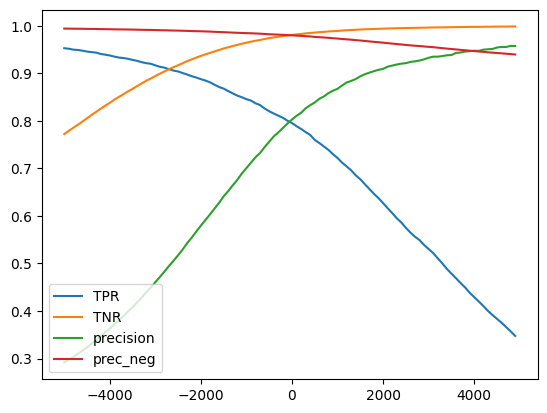

In [106]:
affichage(y_5, y_scores_sgd)

### Forêt aléatoire

In [101]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X, y_5, cv=8, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

In [107]:
affichage(y_5, y_scores_forest, np.linspace(0.1, 0.9, 150))
affichage(y_5, y_scores_forest, np.linspace(0.27, 0.35, 150))

# (3) Classification multi-classe


In [103]:
X = Train_img.copy()
y = Train_lab.copy()

def affichage(y_true, y_proba, thresholds = range(-5000, 5000, 100), scoresToPrint = ['TPR', 'TNR', 'precision', 'prec_neg']):
    nbThreshold = len(thresholds)
    TP, FP, TN, FN = np.zeros(nbClasses, nbThreshold), np.zeros(nbClasses, nbThreshold), np.zeros(nbClasses, nbThreshold), np.zeros(nbClasses, nbThreshold)

    nbClasses = len(np.unique(y_true)) # Nombre de classes
    
    # Récupération des vrais/faux positifs/négatifs
    for i in range(nbClasses):
        for j, threshold in enumerate(thresholds):
            y_pred = y_proba[:, i] > threshold
            confusion = confusion_matrix(y_true, y_pred)

            TP[i, j] = confusion[1][1]
            FP[i, j] = confusion[0][1]
            
            TN[i, j] = confusion[0][0]
            FN[i, j] = confusion[1][0]

    for score in scoresToPrint:
        match score:
            case 'TPR': plt.plot(thresholds, TP / (TP + FN), label = score)
            case 'TNR': plt.plot(thresholds, TN / (TN + FP), label = score)
            case 'precision': plt.plot(thresholds, TP / (TP + FP), label = score)
            case 'prec_neg': plt.plot(thresholds, TN / (TN + FN), label = score)
        
    plt.legend(loc="lower left")
    plt.show()


Deux stratégies:
* OneVsAll: On entraine un classificateur comme ci-dessus par classe.
* OneVsOne: On entraine n(n-1)/2 classificateurs avec un jeu de données restreint à deux classes.

En général, on utilise le OneVsAll. Le OneVsOne est utile lorsqu'un algorithme préfère de petits jeux de données (comme le SVM).

```SGDClassifier``` utilise la stratégie OneVsAll par défaut lorsqu'on lui donne un jeu de données multi-classe:

In [27]:
sgd_clf = SGDClassifier(random_state=42) 
y_scores_sgd = cross_val_predict(sgd_clf, X, Y, cv=3, method="decision_function")

array([-29613.12605767,  27082.35774008, -54591.21673055, ...,
       -60262.4062281 , -57128.52065763,  38126.23875451])

heelo: 2 and 3
